In [11]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval
import warnings
warnings.filterwarnings('ignore')

In [19]:
import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        predict = np.squeeze(self.model.predict_classes(self.validation_data[0]))
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

In [13]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [14]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [15]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [16]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


## Carga de datos

#### Metadata 

In [17]:
x_all=np.load("../obj4/LC_features/MetadataLC.npy")

x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 8) (4339,)
Objetos de validación: (1918, 8) (1918,)


In [23]:
meta = Sequential()
meta.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
meta.add(Dropout(0.5))
meta.add(Dense(1, activation='sigmoid'))
meta.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1152      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 319us/step - loss: 0.6161 - acc: 0.6548 - val_loss: 0.6046 - val_acc: 0.6659
Epoch 2/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.5288 - acc: 0.7344 - val_loss: 0.5687 - val_acc: 0.7005
Epoch 3/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.4847 - acc: 0.7519 - val_loss: 0.5441 - val_acc: 0.7212
Epoch 4/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.4593 - acc: 0.7731 - val_loss: 0.5224 - val_acc: 0.7373
Epoch 5/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.4417 - acc: 0.7841 - val_loss: 0.5031 - val_acc: 0.7488
Epoch 6/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.4241 - acc: 0.7941 - val_loss: 0.4889 - val_acc: 0.7719
Epoch 7/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.4123 - acc: 0.8028 - val_loss: 0.4751 - val_acc: 0.7742


3905/3905 [==============================] - 0s 49us/step - loss: 0.3416 - acc: 0.8507 - val_loss: 0.3788 - val_acc: 0.8341
Epoch 36/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3404 - acc: 0.8494 - val_loss: 0.3798 - val_acc: 0.8341
Epoch 37/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3386 - acc: 0.8525 - val_loss: 0.3780 - val_acc: 0.8410
Epoch 38/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3394 - acc: 0.8494 - val_loss: 0.3783 - val_acc: 0.8433
Epoch 39/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3399 - acc: 0.8438 - val_loss: 0.3786 - val_acc: 0.8341
Epoch 40/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3360 - acc: 0.8497 - val_loss: 0.3767 - val_acc: 0.8272
Epoch 41/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3317 - acc: 0.8520 - val_loss: 0.3752 - val_acc: 0.8318
Epoch 42/200
3905/3905 [==============================

3905/3905 [==============================] - 0s 42us/step - loss: 0.3249 - acc: 0.8581 - val_loss: 0.3639 - val_acc: 0.8433
Epoch 70/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3167 - acc: 0.8622 - val_loss: 0.3647 - val_acc: 0.8387
Epoch 71/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3254 - acc: 0.8594 - val_loss: 0.3628 - val_acc: 0.8433
Epoch 72/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3286 - acc: 0.8569 - val_loss: 0.3637 - val_acc: 0.8387
Epoch 73/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3221 - acc: 0.8617 - val_loss: 0.3608 - val_acc: 0.8433
Epoch 74/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3206 - acc: 0.8604 - val_loss: 0.3630 - val_acc: 0.8433
Epoch 75/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3201 - acc: 0.8617 - val_loss: 0.3618 - val_acc: 0.8410
Epoch 76/200
3905/3905 [==============================

3905/3905 [==============================] - 0s 41us/step - loss: 0.3176 - acc: 0.8635 - val_loss: 0.3547 - val_acc: 0.8433
Epoch 104/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.3174 - acc: 0.8638 - val_loss: 0.3529 - val_acc: 0.8387
Epoch 105/200
3905/3905 [==============================] - 0s 53us/step - loss: 0.3180 - acc: 0.8638 - val_loss: 0.3525 - val_acc: 0.8387
Epoch 106/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3100 - acc: 0.8653 - val_loss: 0.3574 - val_acc: 0.8410
Epoch 107/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3174 - acc: 0.8633 - val_loss: 0.3578 - val_acc: 0.8410
Epoch 108/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3187 - acc: 0.8622 - val_loss: 0.3549 - val_acc: 0.8456
Epoch 109/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3166 - acc: 0.8622 - val_loss: 0.3566 - val_acc: 0.8387
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 42us/step - loss: 0.3137 - acc: 0.8653 - val_loss: 0.3517 - val_acc: 0.8410
Epoch 138/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3103 - acc: 0.8666 - val_loss: 0.3516 - val_acc: 0.8364
Epoch 139/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3116 - acc: 0.8686 - val_loss: 0.3486 - val_acc: 0.8387
Epoch 140/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3094 - acc: 0.8630 - val_loss: 0.3488 - val_acc: 0.8433
Epoch 141/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3077 - acc: 0.8666 - val_loss: 0.3494 - val_acc: 0.8479
Epoch 142/200
3905/3905 [==============================] - 0s 48us/step - loss: 0.3076 - acc: 0.8694 - val_loss: 0.3480 - val_acc: 0.8479
Epoch 143/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3126 - acc: 0.8648 - val_loss: 0.3532 - val_acc: 0.8456
Epoch 144/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 49us/step - loss: 0.3081 - acc: 0.8699 - val_loss: 0.3445 - val_acc: 0.8387
Epoch 172/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3068 - acc: 0.8686 - val_loss: 0.3469 - val_acc: 0.8456
Epoch 173/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3097 - acc: 0.8658 - val_loss: 0.3464 - val_acc: 0.8433
Epoch 174/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3054 - acc: 0.8689 - val_loss: 0.3449 - val_acc: 0.8456
Epoch 175/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3111 - acc: 0.8622 - val_loss: 0.3434 - val_acc: 0.8410
Epoch 176/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3152 - acc: 0.8650 - val_loss: 0.3470 - val_acc: 0.8456
Epoch 177/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3087 - acc: 0.8666 - val_loss: 0.3459 - val_acc: 0.8410
Epoch 178/200
3905/3905 [=======================

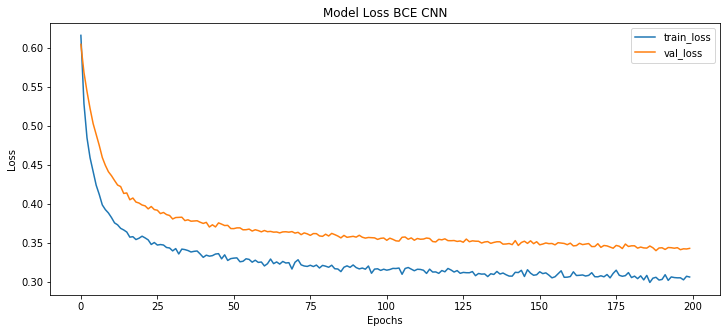

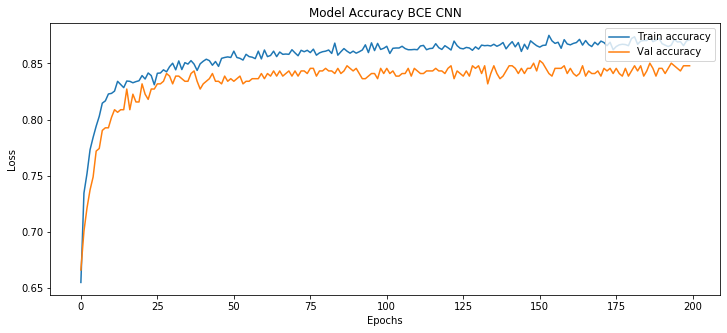

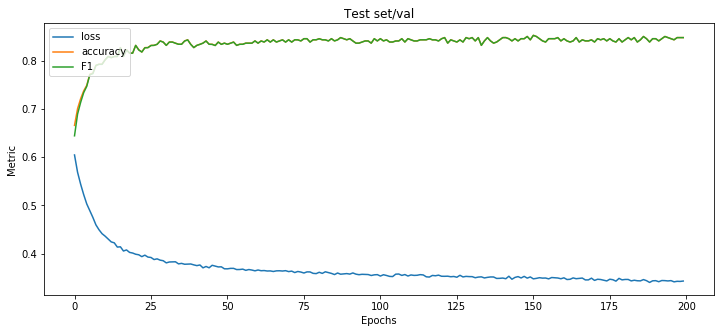

In [24]:
train_model(meta, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='baseline_metadata.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               1152      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.920775,0.838813,0.877885,0.850541,0.838805,0.848279
Confirmed,0.742967,0.865872,0.799725,0.850541,0.838805,0.848279


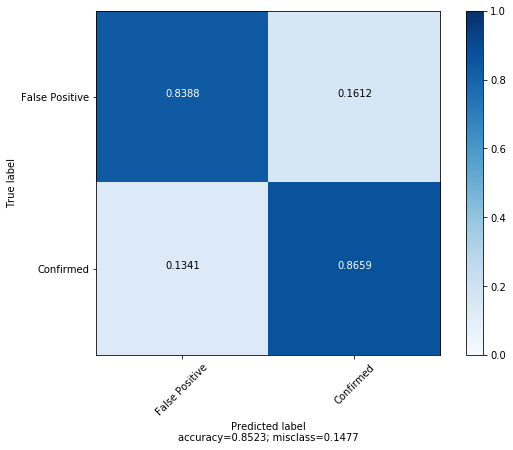

{'Precision raw': array([0.92077465, 0.74296675]),
 'Recall raw': array([0.83881315, 0.86587183]),
 'F1 raw': array([0.87788502, 0.79972471]),
 'F1 weighted': 0.8505411351833697,
 'F1 macro': 0.8388048631927403,
 'F1 micro': 0.848279457768509,
 'Confusion Matrix': array([[1046,  201],
        [  90,  581]])}

In [25]:
meta_loaded = keras.models.load_model("baseline_metadata.hdf5") #con 4 capas (64 y 128) con dropa en todo
meta_loaded.summary()

predichos=meta_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - METADATA') #con 3 capas aumentando/double

#### Fourier Folded PCA

In [26]:
x_all=np.load("../obj4/LC_features/FourierPCA_300T_32D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)


Objetos de entrenamiento: (4339, 32) (4339,)
Objetos de validación: (1918, 32) (1918,)


In [27]:
ff = Sequential()
ff.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
ff.add(Dropout(0.5))
ff.add(Dense(1, activation='sigmoid'))
ff.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 1s 358us/step - loss: 1.1209 - acc: 0.4981 - val_loss: 0.6759 - val_acc: 0.6313
Epoch 2/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.7127 - acc: 0.6476 - val_loss: 0.5988 - val_acc: 0.6982
Epoch 3/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.6586 - acc: 0.6825 - val_loss: 0.5737 - val_acc: 0.7074
Epoch 4/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.6247 - acc: 0.6917 - val_loss: 0.5622 - val_acc: 0.7051
Epoch 5/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.5865 - acc: 0.7181 - val_loss: 0.5510 - val_acc: 0.7166
Epoch 6/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.5785 - acc: 0.7168 - val_loss: 0.5474 - val_acc: 0.7327
Epoch 7/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5523 - acc: 0.7229 - val_loss: 0.5394 - val_acc: 0.7327


3905/3905 [==============================] - 0s 40us/step - loss: 0.4353 - acc: 0.7936 - val_loss: 0.5017 - val_acc: 0.7488
Epoch 36/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.4428 - acc: 0.7985 - val_loss: 0.4989 - val_acc: 0.7581
Epoch 37/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4353 - acc: 0.7982 - val_loss: 0.5039 - val_acc: 0.7488
Epoch 38/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.4327 - acc: 0.8044 - val_loss: 0.4937 - val_acc: 0.7581
Epoch 39/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4354 - acc: 0.7949 - val_loss: 0.5029 - val_acc: 0.7558
Epoch 40/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4305 - acc: 0.8020 - val_loss: 0.4982 - val_acc: 0.7627
Epoch 41/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.4276 - acc: 0.8061 - val_loss: 0.5012 - val_acc: 0.7535
Epoch 42/200
3905/3905 [==============================

3905/3905 [==============================] - 0s 41us/step - loss: 0.4063 - acc: 0.8174 - val_loss: 0.4928 - val_acc: 0.7558
Epoch 70/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.4074 - acc: 0.8113 - val_loss: 0.4951 - val_acc: 0.7512
Epoch 71/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3956 - acc: 0.8238 - val_loss: 0.4882 - val_acc: 0.7535
Epoch 72/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4002 - acc: 0.8179 - val_loss: 0.4968 - val_acc: 0.7512
Epoch 73/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.4035 - acc: 0.8156 - val_loss: 0.4862 - val_acc: 0.7581
Epoch 74/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4068 - acc: 0.8108 - val_loss: 0.5013 - val_acc: 0.7465
Epoch 75/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3979 - acc: 0.8166 - val_loss: 0.4921 - val_acc: 0.7558
Epoch 76/200
3905/3905 [==============================

3905/3905 [==============================] - 0s 42us/step - loss: 0.3857 - acc: 0.8269 - val_loss: 0.4933 - val_acc: 0.7627
Epoch 104/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3771 - acc: 0.8323 - val_loss: 0.4908 - val_acc: 0.7558
Epoch 105/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3808 - acc: 0.8292 - val_loss: 0.5007 - val_acc: 0.7535
Epoch 106/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3800 - acc: 0.8312 - val_loss: 0.4936 - val_acc: 0.7650
Epoch 107/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3815 - acc: 0.8279 - val_loss: 0.4998 - val_acc: 0.7581
Epoch 108/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3792 - acc: 0.8323 - val_loss: 0.4884 - val_acc: 0.7558
Epoch 109/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3834 - acc: 0.8287 - val_loss: 0.4976 - val_acc: 0.7581
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 43us/step - loss: 0.3624 - acc: 0.8371 - val_loss: 0.5058 - val_acc: 0.7442
Epoch 138/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3650 - acc: 0.8348 - val_loss: 0.5004 - val_acc: 0.7604
Epoch 139/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3637 - acc: 0.8394 - val_loss: 0.5104 - val_acc: 0.7535
Epoch 140/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3760 - acc: 0.8297 - val_loss: 0.5059 - val_acc: 0.7627
Epoch 141/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3629 - acc: 0.8407 - val_loss: 0.5024 - val_acc: 0.7558
Epoch 142/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3657 - acc: 0.8353 - val_loss: 0.4945 - val_acc: 0.7627
Epoch 143/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3735 - acc: 0.8389 - val_loss: 0.4989 - val_acc: 0.7512
Epoch 144/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 42us/step - loss: 0.3524 - acc: 0.8499 - val_loss: 0.4958 - val_acc: 0.7581
Epoch 172/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3485 - acc: 0.8474 - val_loss: 0.4964 - val_acc: 0.7604
Epoch 173/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3571 - acc: 0.8461 - val_loss: 0.5052 - val_acc: 0.7512
Epoch 174/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3630 - acc: 0.8430 - val_loss: 0.4988 - val_acc: 0.7535
Epoch 175/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3538 - acc: 0.8471 - val_loss: 0.5046 - val_acc: 0.7512
Epoch 176/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3562 - acc: 0.8382 - val_loss: 0.5071 - val_acc: 0.7535
Epoch 177/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3474 - acc: 0.8504 - val_loss: 0.5052 - val_acc: 0.7512
Epoch 178/200
3905/3905 [=======================

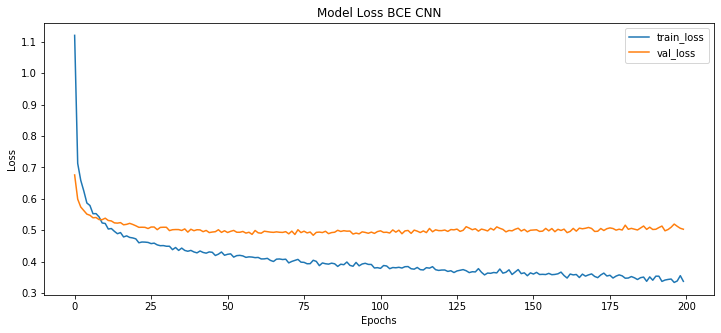

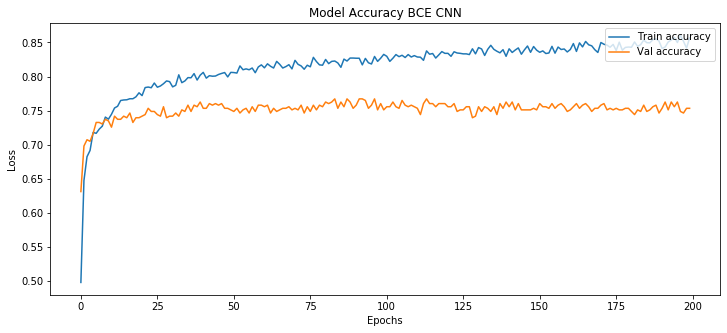

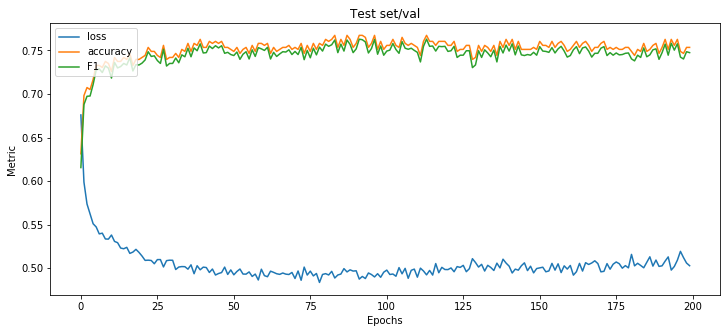

In [28]:
train_model(ff, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='baseline_ffolded.hdf5')

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.839387,0.834002,0.836685,0.788608,0.767972,0.788321
Confirmed,0.695140,0.703428,0.699259,0.788608,0.767972,0.788321


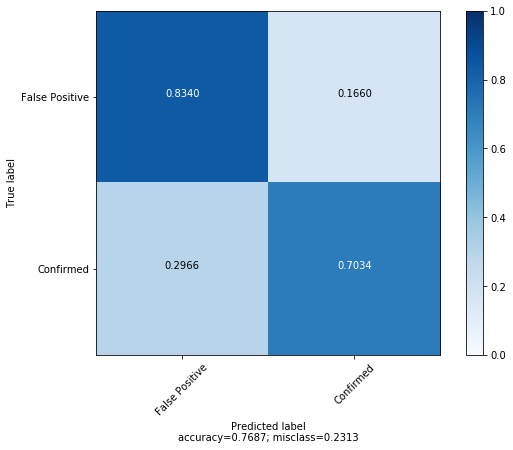

{'Precision raw': array([0.8393866 , 0.69513991]),
 'Recall raw': array([0.8340016 , 0.70342772]),
 'F1 raw': array([0.83668544, 0.69925926]),
 'F1 weighted': 0.7886077709680835,
 'F1 macro': 0.7679723488573046,
 'F1 micro': 0.7883211678832118,
 'Confusion Matrix': array([[1040,  207],
        [ 199,  472]])}

In [29]:
ff_loaded = keras.models.load_model("baseline_ffolded.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=ff_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER FOLDED') #con 3 capas aumentando/double

#### Fourier PCA

Objetos de entrenamiento: (4339, 32) (4339,)
Objetos de validación: (1918, 32) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 2s 394us/step - loss: 2.4623 - acc: 0.6269 - val_loss: 1.3438 - val_acc: 0.6083
Epoch 2/200
3905/3905 [==============================] - 0s 45us/step - loss: 2.0023 - acc: 0.6407 - val_loss: 1.2369 - val_acc: 0.6382
Epoch 3/200
3905/3905 [==============================] - 0s 52us/step - loss: 1.6156 - acc: 0.6515 - val_loss: 1.2356 - val_acc: 0.6198
Epoch 4/200
3905/3905 [==============================] - 0s 53us/step - loss: 1.3505 - acc: 0.6433 - val_loss: 1.1970 - val_acc: 0.6406
Epoch 5/200
3905/3905 [==============================] - 0s 46us/step - loss: 1.1376 - acc: 0.6466 - val_loss: 1.2502 - val_acc: 0.6152
Epoch 6/200
3905/3905 [==============================] - 0s 45us/step - loss: 1.0460 - acc: 0.6433 - val_loss: 1.2274 - val_acc: 0.6244
Epoch 7/200
3905/3905 [==========================

Epoch 35/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.5477 - acc: 0.6909 - val_loss: 0.7238 - val_acc: 0.6521
Epoch 36/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5396 - acc: 0.7096 - val_loss: 0.7016 - val_acc: 0.6359
Epoch 37/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.5390 - acc: 0.7001 - val_loss: 0.7387 - val_acc: 0.6267
Epoch 38/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5319 - acc: 0.6983 - val_loss: 0.6942 - val_acc: 0.6498
Epoch 39/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.5341 - acc: 0.6963 - val_loss: 0.7457 - val_acc: 0.5853
Epoch 40/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.5295 - acc: 0.7140 - val_loss: 0.6711 - val_acc: 0.6267
Epoch 41/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.5251 - acc: 0.7073 - val_loss: 0.6488 - val_acc: 0.6336
Epoch 42/200
3905/3905 [=================

3905/3905 [==============================] - 0s 49us/step - loss: 0.5068 - acc: 0.7170 - val_loss: 0.6077 - val_acc: 0.6521
Epoch 70/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.5118 - acc: 0.7239 - val_loss: 0.6334 - val_acc: 0.6452
Epoch 71/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.5122 - acc: 0.7250 - val_loss: 0.6446 - val_acc: 0.6429
Epoch 72/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.5073 - acc: 0.7227 - val_loss: 0.6759 - val_acc: 0.5853
Epoch 73/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.5080 - acc: 0.7055 - val_loss: 0.6428 - val_acc: 0.6313
Epoch 74/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.5105 - acc: 0.7175 - val_loss: 0.6438 - val_acc: 0.6382
Epoch 75/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.5031 - acc: 0.7181 - val_loss: 0.6185 - val_acc: 0.6521
Epoch 76/200
3905/3905 [==============================

3905/3905 [==============================] - 0s 42us/step - loss: 0.5032 - acc: 0.7239 - val_loss: 0.6205 - val_acc: 0.6406
Epoch 104/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.4975 - acc: 0.7283 - val_loss: 0.6306 - val_acc: 0.6636
Epoch 105/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4952 - acc: 0.7316 - val_loss: 0.6337 - val_acc: 0.6382
Epoch 106/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4976 - acc: 0.7237 - val_loss: 0.6356 - val_acc: 0.6175
Epoch 107/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4932 - acc: 0.7321 - val_loss: 0.6126 - val_acc: 0.6244
Epoch 108/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4973 - acc: 0.7242 - val_loss: 0.6168 - val_acc: 0.6590
Epoch 109/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4946 - acc: 0.7296 - val_loss: 0.6153 - val_acc: 0.6498
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 44us/step - loss: 0.4863 - acc: 0.7401 - val_loss: 0.6277 - val_acc: 0.6659
Epoch 138/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4835 - acc: 0.7278 - val_loss: 0.6268 - val_acc: 0.6636
Epoch 139/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4887 - acc: 0.7360 - val_loss: 0.6318 - val_acc: 0.6544
Epoch 140/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.4809 - acc: 0.7455 - val_loss: 0.6165 - val_acc: 0.6544
Epoch 141/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4758 - acc: 0.7465 - val_loss: 0.6210 - val_acc: 0.6774
Epoch 142/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4825 - acc: 0.7365 - val_loss: 0.6320 - val_acc: 0.6498
Epoch 143/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.4834 - acc: 0.7360 - val_loss: 0.6404 - val_acc: 0.6590
Epoch 144/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 43us/step - loss: 0.4749 - acc: 0.7426 - val_loss: 0.6499 - val_acc: 0.6613
Epoch 172/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.4724 - acc: 0.7434 - val_loss: 0.6597 - val_acc: 0.6498
Epoch 173/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4755 - acc: 0.7401 - val_loss: 0.6564 - val_acc: 0.6382
Epoch 174/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4658 - acc: 0.7493 - val_loss: 0.6486 - val_acc: 0.6498
Epoch 175/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.4681 - acc: 0.7506 - val_loss: 0.6752 - val_acc: 0.6359
Epoch 176/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4694 - acc: 0.7472 - val_loss: 0.6619 - val_acc: 0.6567
Epoch 177/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.4791 - acc: 0.7408 - val_loss: 0.6415 - val_acc: 0.6774
Epoch 178/200
3905/3905 [=======================

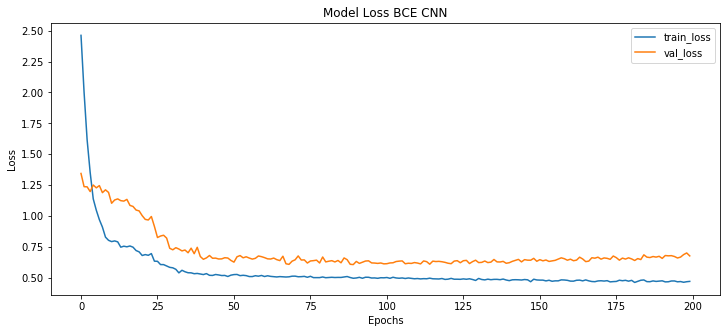

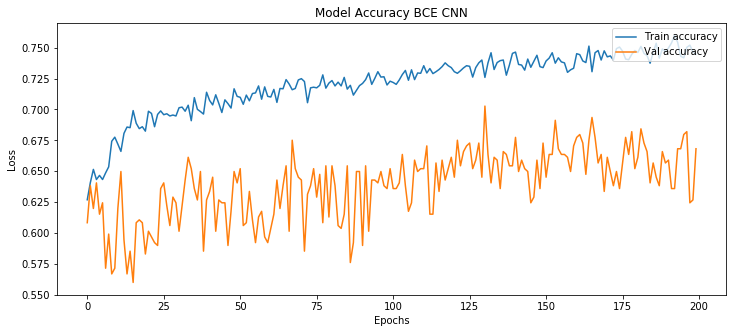

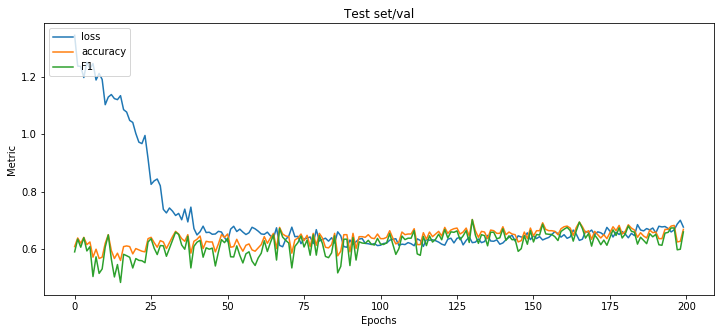

In [30]:
x_all=np.load("../obj4/LC_features/FourierPCA_71427T_32D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

f = Sequential()
f.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
f.add(Dropout(0.5))
f.add(Dense(1, activation='sigmoid'))

train_model(f, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='baseline_funfolded.hdf5')

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.771982,0.830794,0.800309,0.725126,0.692857,0.730448
Confirmed,0.633681,0.543964,0.585405,0.725126,0.692857,0.730448


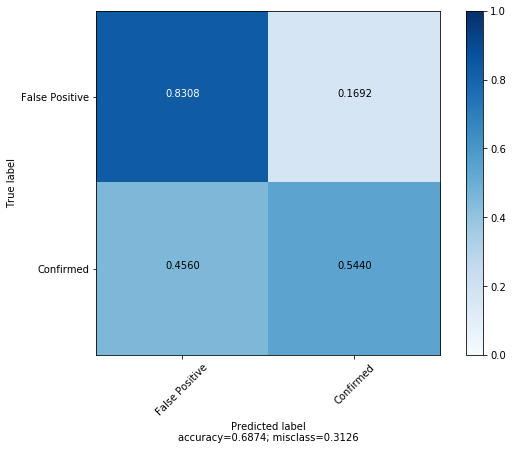

{'Precision raw': array([0.77198212, 0.63368056]),
 'Recall raw': array([0.83079391, 0.54396423]),
 'F1 raw': array([0.800309  , 0.58540497]),
 'F1 weighted': 0.7251262036940289,
 'F1 macro': 0.6928569857731945,
 'F1 micro': 0.7304483837330553,
 'Confusion Matrix': array([[1036,  211],
        [ 306,  365]])}

In [31]:
f_loaded = keras.models.load_model("baseline_funfolded.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=f_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - FOURIER UNFOLDED') #con 3 capas aumentando/double

#### VAE 

Objetos de entrenamiento: (4339, 32) (4339,)
Objetos de validación: (1918, 32) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 2s 452us/step - loss: 0.5839 - acc: 0.6633 - val_loss: 0.5622 - val_acc: 0.7005
Epoch 2/200
3905/3905 [==============================] - 0s 46us/step - loss: 0.4822 - acc: 0.7746 - val_loss: 0.4964 - val_acc: 0.7696
Epoch 3/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.4489 - acc: 0.8000 - val_loss: 0.4667 - val_acc: 0.7811
Epoch 4/200
3905/3905 [==============================] - 0s 52us/step - loss: 0.4296 - acc: 0.8026 - val_loss: 0.4502 - val_acc: 0.7880
Epoch 5/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.4234 - acc: 0.8056 - val_loss: 0.4456 - val_acc: 0.7926
Epoch 6/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.4177 - acc: 0.8115 - val_loss: 0.4408 - val_acc: 0.7926
Epoch 7/200
3905/3905 [==========================

Epoch 35/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3733 - acc: 0.8387 - val_loss: 0.4305 - val_acc: 0.7995
Epoch 36/200
3905/3905 [==============================] - 0s 49us/step - loss: 0.3717 - acc: 0.8330 - val_loss: 0.4269 - val_acc: 0.7995
Epoch 37/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3716 - acc: 0.8353 - val_loss: 0.4316 - val_acc: 0.7995
Epoch 38/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3714 - acc: 0.8343 - val_loss: 0.4288 - val_acc: 0.7995
Epoch 39/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.3690 - acc: 0.8348 - val_loss: 0.4305 - val_acc: 0.7995
Epoch 40/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3674 - acc: 0.8335 - val_loss: 0.4256 - val_acc: 0.8018
Epoch 41/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3675 - acc: 0.8312 - val_loss: 0.4261 - val_acc: 0.8018
Epoch 42/200
3905/3905 [=================

3905/3905 [==============================] - 0s 42us/step - loss: 0.3467 - acc: 0.8435 - val_loss: 0.4272 - val_acc: 0.7995
Epoch 70/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3513 - acc: 0.8438 - val_loss: 0.4229 - val_acc: 0.7995
Epoch 71/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3446 - acc: 0.8476 - val_loss: 0.4250 - val_acc: 0.7995
Epoch 72/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3495 - acc: 0.8430 - val_loss: 0.4238 - val_acc: 0.7949
Epoch 73/200
3905/3905 [==============================] - 0s 51us/step - loss: 0.3503 - acc: 0.8430 - val_loss: 0.4214 - val_acc: 0.7949
Epoch 74/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3475 - acc: 0.8471 - val_loss: 0.4236 - val_acc: 0.7949
Epoch 75/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3442 - acc: 0.8443 - val_loss: 0.4239 - val_acc: 0.7972
Epoch 76/200
3905/3905 [==============================

3905/3905 [==============================] - 0s 44us/step - loss: 0.3372 - acc: 0.8515 - val_loss: 0.4220 - val_acc: 0.7972
Epoch 104/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.3381 - acc: 0.8476 - val_loss: 0.4237 - val_acc: 0.7949
Epoch 105/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3294 - acc: 0.8530 - val_loss: 0.4252 - val_acc: 0.7972
Epoch 106/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3295 - acc: 0.8604 - val_loss: 0.4247 - val_acc: 0.7995
Epoch 107/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3332 - acc: 0.8528 - val_loss: 0.4268 - val_acc: 0.7972
Epoch 108/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3379 - acc: 0.8558 - val_loss: 0.4273 - val_acc: 0.7949
Epoch 109/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3315 - acc: 0.8525 - val_loss: 0.4249 - val_acc: 0.7972
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 43us/step - loss: 0.3183 - acc: 0.8584 - val_loss: 0.4295 - val_acc: 0.7995
Epoch 138/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3277 - acc: 0.8543 - val_loss: 0.4271 - val_acc: 0.7995
Epoch 139/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3316 - acc: 0.8548 - val_loss: 0.4317 - val_acc: 0.8018
Epoch 140/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3252 - acc: 0.8556 - val_loss: 0.4322 - val_acc: 0.7972
Epoch 141/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3247 - acc: 0.8551 - val_loss: 0.4284 - val_acc: 0.7926
Epoch 142/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.3270 - acc: 0.8538 - val_loss: 0.4290 - val_acc: 0.7949
Epoch 143/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3270 - acc: 0.8569 - val_loss: 0.4267 - val_acc: 0.7972
Epoch 144/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 43us/step - loss: 0.3185 - acc: 0.8589 - val_loss: 0.4329 - val_acc: 0.7995
Epoch 172/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3128 - acc: 0.8625 - val_loss: 0.4300 - val_acc: 0.7995
Epoch 173/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3129 - acc: 0.8617 - val_loss: 0.4333 - val_acc: 0.7995
Epoch 174/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3156 - acc: 0.8612 - val_loss: 0.4299 - val_acc: 0.7972
Epoch 175/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3142 - acc: 0.8579 - val_loss: 0.4318 - val_acc: 0.7972
Epoch 176/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3161 - acc: 0.8566 - val_loss: 0.4313 - val_acc: 0.7972
Epoch 177/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3116 - acc: 0.8633 - val_loss: 0.4338 - val_acc: 0.7949
Epoch 178/200
3905/3905 [=======================

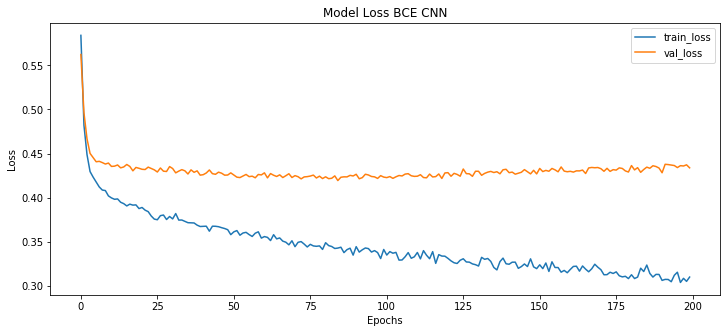

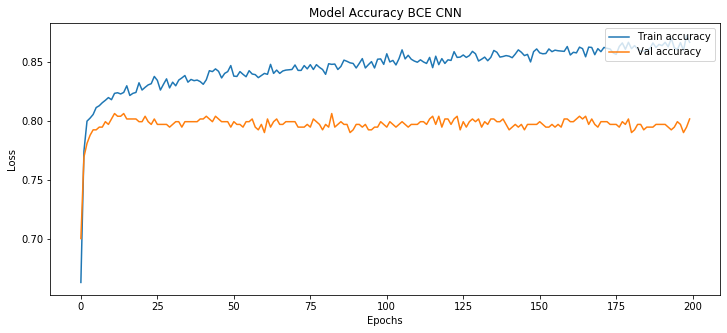

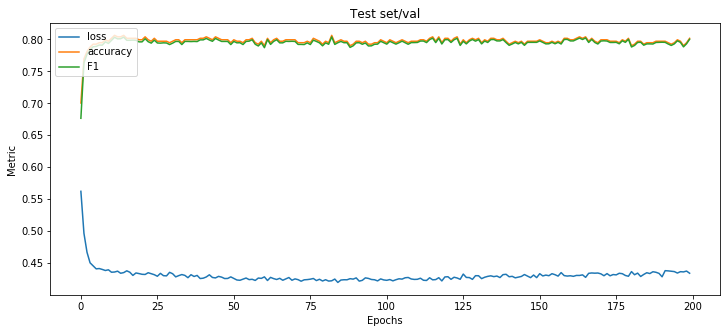

In [32]:
x_all=np.load("../obj4/LC_features/VAE_300T_32D.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

VAE = Sequential()
VAE.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
VAE.add(Dropout(0.5))
VAE.add(Dense(1, activation='sigmoid'))

train_model(VAE, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='baseline_VAE.hdf5')

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.869636,0.861267,0.865431,0.826211,0.809377,0.82586
Confirmed,0.746706,0.760060,0.753323,0.826211,0.809377,0.82586


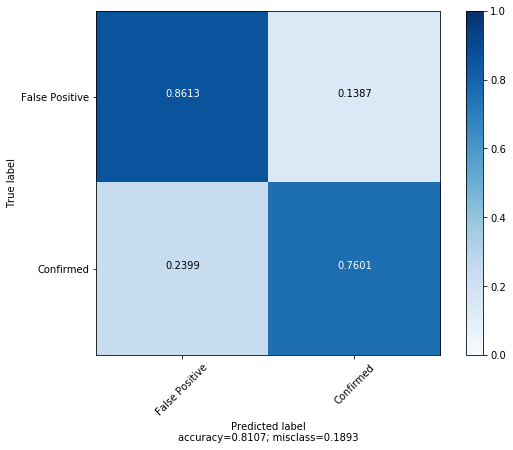

{'Precision raw': array([0.86963563, 0.74670571]),
 'Recall raw': array([0.86126704, 0.76005961]),
 'F1 raw': array([0.8654311 , 0.75332349]),
 'F1 weighted': 0.8262109727361239,
 'F1 macro': 0.8093772949579661,
 'F1 micro': 0.8258602711157456,
 'Confusion Matrix': array([[1074,  173],
        [ 161,  510]])}

In [33]:
VAE_loaded = keras.models.load_model("baseline_VAE.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=VAE_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE') #con 3 capas aumentando/double

#### VAE sample

Objetos de entrenamiento: (4339, 32) (4339,)
Objetos de validación: (1918, 32) (1918,)
Train on 3905 samples, validate on 434 samples
Epoch 1/200
3905/3905 [==============================] - 2s 480us/step - loss: 0.7855 - acc: 0.5037 - val_loss: 0.6248 - val_acc: 0.6590
Epoch 2/200
3905/3905 [==============================] - 0s 45us/step - loss: 0.5815 - acc: 0.6809 - val_loss: 0.5944 - val_acc: 0.6590
Epoch 3/200
3905/3905 [==============================] - 0s 52us/step - loss: 0.5312 - acc: 0.7306 - val_loss: 0.5564 - val_acc: 0.7074
Epoch 4/200
3905/3905 [==============================] - 0s 58us/step - loss: 0.5017 - acc: 0.7490 - val_loss: 0.5340 - val_acc: 0.7166
Epoch 5/200
3905/3905 [==============================] - 0s 40us/step - loss: 0.4880 - acc: 0.7654 - val_loss: 0.5196 - val_acc: 0.7212
Epoch 6/200
3905/3905 [==============================] - 0s 50us/step - loss: 0.4709 - acc: 0.7729 - val_loss: 0.5061 - val_acc: 0.7350
Epoch 7/200
3905/3905 [==========================

Epoch 35/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3944 - acc: 0.8236 - val_loss: 0.4871 - val_acc: 0.7535
Epoch 36/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3973 - acc: 0.8159 - val_loss: 0.4916 - val_acc: 0.7488
Epoch 37/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3873 - acc: 0.8287 - val_loss: 0.4894 - val_acc: 0.7535
Epoch 38/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3867 - acc: 0.8243 - val_loss: 0.4914 - val_acc: 0.7442
Epoch 39/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3879 - acc: 0.8259 - val_loss: 0.4906 - val_acc: 0.7465
Epoch 40/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3879 - acc: 0.8261 - val_loss: 0.4915 - val_acc: 0.7535
Epoch 41/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3856 - acc: 0.8200 - val_loss: 0.4942 - val_acc: 0.7488
Epoch 42/200
3905/3905 [=================

3905/3905 [==============================] - 0s 43us/step - loss: 0.3695 - acc: 0.8353 - val_loss: 0.5101 - val_acc: 0.7512
Epoch 70/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3633 - acc: 0.8376 - val_loss: 0.5120 - val_acc: 0.7488
Epoch 71/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3601 - acc: 0.8399 - val_loss: 0.5134 - val_acc: 0.7419
Epoch 72/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3611 - acc: 0.8376 - val_loss: 0.5164 - val_acc: 0.7465
Epoch 73/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3681 - acc: 0.8376 - val_loss: 0.5095 - val_acc: 0.7558
Epoch 74/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3652 - acc: 0.8369 - val_loss: 0.5161 - val_acc: 0.7512
Epoch 75/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3625 - acc: 0.8399 - val_loss: 0.5142 - val_acc: 0.7465
Epoch 76/200
3905/3905 [==============================

3905/3905 [==============================] - 0s 42us/step - loss: 0.3483 - acc: 0.8420 - val_loss: 0.5271 - val_acc: 0.7373
Epoch 104/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3558 - acc: 0.8410 - val_loss: 0.5287 - val_acc: 0.7373
Epoch 105/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3546 - acc: 0.8410 - val_loss: 0.5254 - val_acc: 0.7373
Epoch 106/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3487 - acc: 0.8464 - val_loss: 0.5269 - val_acc: 0.7373
Epoch 107/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3440 - acc: 0.8494 - val_loss: 0.5297 - val_acc: 0.7419
Epoch 108/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3499 - acc: 0.8440 - val_loss: 0.5276 - val_acc: 0.7396
Epoch 109/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3511 - acc: 0.8417 - val_loss: 0.5282 - val_acc: 0.7373
Epoch 110/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 43us/step - loss: 0.3280 - acc: 0.8540 - val_loss: 0.5433 - val_acc: 0.7304
Epoch 138/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3337 - acc: 0.8561 - val_loss: 0.5441 - val_acc: 0.7304
Epoch 139/200
3905/3905 [==============================] - 0s 44us/step - loss: 0.3343 - acc: 0.8563 - val_loss: 0.5461 - val_acc: 0.7258
Epoch 140/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3453 - acc: 0.8382 - val_loss: 0.5427 - val_acc: 0.7327
Epoch 141/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3437 - acc: 0.8433 - val_loss: 0.5441 - val_acc: 0.7304
Epoch 142/200
3905/3905 [==============================] - 0s 41us/step - loss: 0.3350 - acc: 0.8504 - val_loss: 0.5436 - val_acc: 0.7350
Epoch 143/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3381 - acc: 0.8497 - val_loss: 0.5449 - val_acc: 0.7327
Epoch 144/200
3905/3905 [=======================

3905/3905 [==============================] - 0s 43us/step - loss: 0.3328 - acc: 0.8553 - val_loss: 0.5599 - val_acc: 0.7281
Epoch 172/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3284 - acc: 0.8525 - val_loss: 0.5600 - val_acc: 0.7258
Epoch 173/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3274 - acc: 0.8476 - val_loss: 0.5618 - val_acc: 0.7235
Epoch 174/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3348 - acc: 0.8504 - val_loss: 0.5636 - val_acc: 0.7281
Epoch 175/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3315 - acc: 0.8504 - val_loss: 0.5664 - val_acc: 0.7304
Epoch 176/200
3905/3905 [==============================] - 0s 43us/step - loss: 0.3408 - acc: 0.8446 - val_loss: 0.5570 - val_acc: 0.7304
Epoch 177/200
3905/3905 [==============================] - 0s 42us/step - loss: 0.3353 - acc: 0.8522 - val_loss: 0.5596 - val_acc: 0.7350
Epoch 178/200
3905/3905 [=======================

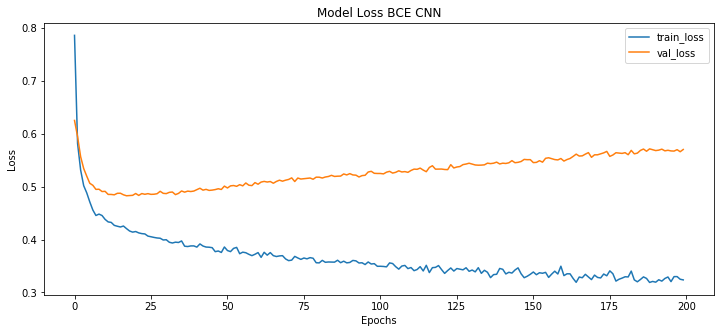

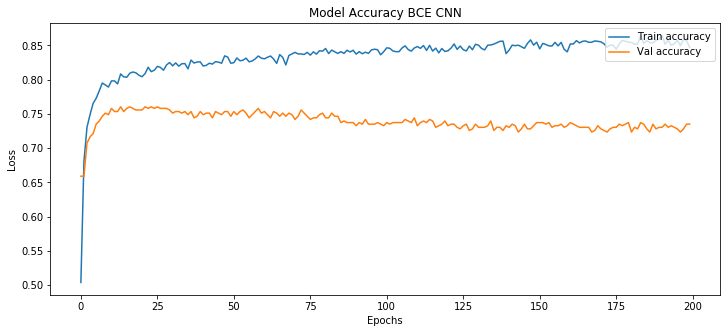

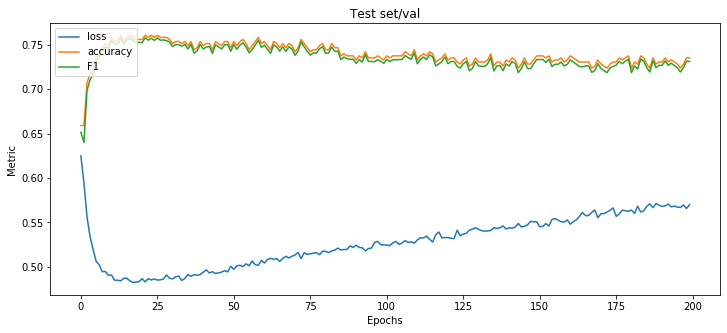

In [34]:
x_all=np.load("../obj4/LC_features/VAE_300T_32D_samp.npy")
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

VAEs = Sequential()
VAEs.add(Dense(128, input_shape=x_train.shape[1:], activation='relu'))
VAEs.add(Dropout(0.5))
VAEs.add(Dense(1, activation='sigmoid'))

train_model(VAEs, x_train, y_train, x_val, y_val, e=200, BS=128, focal=False,alpha=0.6,save_f='baseline_VAEs.hdf5')

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.834385,0.848436,0.841352,0.791186,0.769654,0.791971
Confirmed,0.709231,0.687034,0.697956,0.791186,0.769654,0.791971


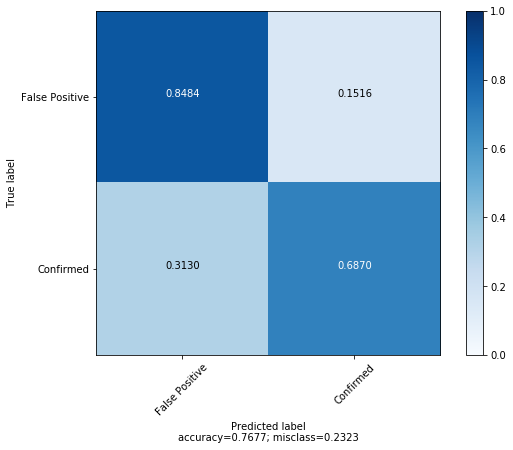

{'Precision raw': array([0.83438486, 0.70923077]),
 'Recall raw': array([0.84843625, 0.68703428]),
 'F1 raw': array([0.84135189, 0.69795609]),
 'F1 weighted': 0.7911857894445271,
 'F1 macro': 0.7696539912681368,
 'F1 micro': 0.791970802919708,
 'Confusion Matrix': array([[1058,  189],
        [ 210,  461]])}

In [35]:
VAEs_loaded = keras.models.load_model("baseline_VAEs.hdf5") #con 4 capas (64 y 128) con dropa en todo
#ff_loaded.summary()

predichos=VAEs_loaded.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 200 epochs - VAE sample') #con 3 capas aumentando/double